## Predicting Soccer Outcomes Using MLE and MAP

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
from scipy.stats import poisson
from scipy.optimize import minimize
from scipy.optimize import minimize, NonlinearConstraint

To learn new technical concepts, I always like to use an interesting application. Something that the outcome is so appealing that force ourselves to keep going despite how hard some parts of the concept might be.

Well, despite being Brazilian, I am no big soccer fan, in fact I know almost nothing, but being able to predict their results is something that always caught my attention. Given how big betting\* sites are today, I believe I am not the only one.



 <sub>*DO NOT use this model to bet. It is really simplified. You WILL lose money.*</sub>

### So, let's try to do it!

The first step in any modelling endeavour is to define a model. A model is a mathematical construct, a simplified version of reality that we can work with, based on some premisses.

We may start assuming that the number of goals of each team are independent of each other, this might not be totally realistic, as one team is scoring, the other cannot be scoring too. But simplify a lot at little loss. The standard choice for any problem where things arrive randomly(either goals, people in a place or lightnings in a farm) is the Poisson process. In a Poisson process, the number of events (goals, arrives, strikes) in a period, in our case the full match, follows a Poisson distribution.

$$
P(\rm{Goal} = g | \lambda) = \frac{\lambda^{g} e^{-\lambda}}{g!}
$$

Where $\lambda$ is the rate of the events, and the average number of gols is $\mathbb{E}[g] = \lambda$.

Each team score will follow this process, independently.

What about $\lambda$? Well, it is also sensible to say that a goal is the result of the interaction between one teams attack ($\alpha$) against the other team defense ($\beta$). There is also the home advantage ($\gamma$) that plays an important role in most sports. We can define the Home ($h$) and Away ($a$) teams rates as:

$$
\lambda^{h} = \alpha^{h} + \gamma - \beta^{a} \\
\lambda^{a} = \alpha^{a} - \beta^{h}
$$

We can try many different combinations here. We can multiply instead of sum, have a home advantage for the defense, add extra parameters for the weather, altitude etc, but this model has a good balance between complexity, tractability and avoiding overfitting (the more degrees of freedom, easier it is to overfit). We will also assume that $\gamma$ is the same for all teams and fixed in time. 


Let's start our code with an artificial example of the distribution of goals, given some parameters:

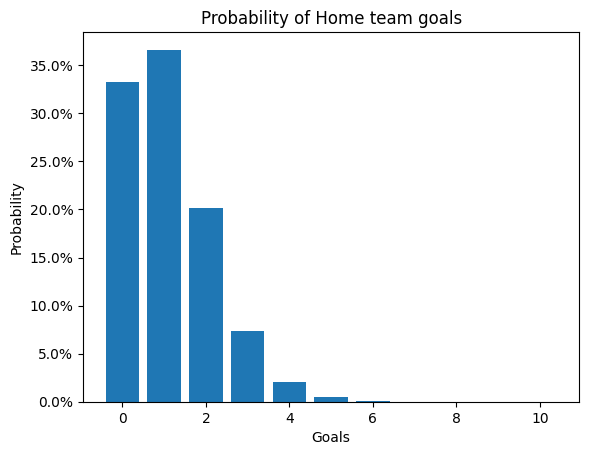

In [2]:
gamma = 0.1
home_atk = 3.5
away_def = 2.5

lambda_ = gamma + home_atk - away_def 

goals = np.arange(0, 11)

factorial = np.vectorize(math.factorial)

pois = lambda g: (lambda_ ** g)*np.exp(-lambda_)/factorial(g)

plt.bar(goals, pois(goals))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Goals')
plt.ylabel('Probability')
plt.title('Probability of Home team goals')
plt.show()

The numbers seems inline with actual soccer games, right? Lots of 0 and 1 goals, with probabilities decreasing fast for higher goals. Events like 7x1 are really rare... actually, let's not talk about that...

_Ok, Andre. If I had the parameters, I could model the goals probabilities, if I had..._

### Inference with Maximum Likelihood estimation

To find the teams parameters we are look to historical data. We are explicitly assuming that the parameters are static or changing really slowly.

But before starting the estimation, let's import our data: The results of Premier League, season 2018-2019.

In [3]:
data = pd.read_csv('premier_league_1819.csv', sep=',')

In [4]:
data.head()

,home,away,home_goal,away_goal
0,Manchester United,Leicester City,2,1
1,Newcastle United,Tottenham Hotspur,1,2
2,AFC Bournemouth,Cardiff City,2,0
3,Fulham,Crystal Palace,0,2
4,Huddersfield Town,Chelsea,0,3


In [5]:
print(f'{len(data)} matches')

380 matches


Split the data into the training set (where the parameters will be learned), validation set (in case we need to optimize some hyperparameters*) and test set (where we check how good our model is in new, unseen, date.)

\* hyperparameters are parameters that control the training process and must be set independently.

In [6]:
n_train = 150
n_validation = 200

data_train = data[:n_train]
data_validation = data[n_train:n_validation]
data_test = data[n_validation:]

In [7]:
# Initial parameters table

teams = pd.unique(data[['home', 'away']].values.ravel('K'))
teams_params = pd.DataFrame({
    'Team': teams,
    'alpha': 5,
    'beta': 2
})

teams_params.set_index('Team', inplace=True)

In [8]:
teams_params

,alpha,beta
Team,,
Manchester United,5,2
Newcastle United,5,2
AFC Bournemouth,5,2
Fulham,5,2
Huddersfield Town,5,2
Watford,5,2
Wolverhampton Wanderers,5,2
Liverpool,5,2
Southampton,5,2


In the parameters estimation, I am going to use the maximum likelihood approach. The basic idea is to find the set of parameters $(\{\alpha^i\}_i, \{\beta^i\}_i, \gamma)$, such that what actually happened is the most probable result. For a match, is the probability of the home team score, times the away team score. For multiple events, we multiply the probability of individual events.

Our objective is to choose $(\{\alpha^i\}_i, \{\beta^i\}_i, \gamma)$ to maxize:
$$
\mathbb{P}[\rm{Championship}] = \prod_i^n \frac{(\alpha_i^{h} + \gamma - \beta_i^{a})^{g^h_i} e^{-(\alpha_i^{h} + \gamma - \beta_i^{a})}}{g^h_i!} \frac{(\alpha^{a}_i - \beta^{h}_i)^{g^a_i} e^{-(\alpha^{a}_i - \beta^{h}_i)}}{g^a_i!}
$$


These probabilities get smaller and smaller at each event, but luckily maximize the probability is the same as maximize its logarithm and logarithm turn multiplication into sum. It is also usual to actually minimize the negative of the log-likelihood (I guess because routines are usually written for minimization instead of maximization) the The log-probability of a Poisson distribution is:

$$
\log P(\rm{Goal} = g | \lambda) = g\log{\lambda} - \lambda - \log{g!}
$$


\* Noway I will rewrite that whole formula in its log version. You got the idea.

In [9]:
#Function that calculate the log_likelihood given set of parameters and historical data.

def log_likelihood(params, data, teams=None):
    
    ## Pass params as [data_test_compare, gamma]
    if len(params) == 2:
        gamma = params[1]
        teams_params = params[0]
    
    # Pass params as flatten data_test_compare and gamma
    # Reconstruct the data_test_compare
    else:
        gamma = params[-1]
        params = params[:-1]
        teams_params = pd.DataFrame({
            'Team': teams,
            'alpha': params[:len(teams)],
            'beta': params[len(teams):2*len(teams)]
        }).set_index('Team')
    
    total_sum = 0
    
    for _, row in data.iterrows():
        name_h = row['home']
        name_a = row['away']
        home_goal = row['home_goal']
        away_goal = row['away_goal']

        
        alpha_h = teams_params.at[name_h, 'alpha']
        beta_h = teams_params.at[name_h, 'beta']

        alpha_a = teams_params.at[name_a, 'alpha']
        beta_a = teams_params.at[name_a, 'beta']
        

        lambda_h = gamma + alpha_h - beta_a
        lambda_a = alpha_a - beta_h


        row_sum = poisson.logpmf(home_goal, lambda_h) + poisson.logpmf(away_goal, lambda_a)
        total_sum += row_sum
    
    return -total_sum.tolist()

Sometimes, the minimization can be solved analytical, but in our case is better to use some solver routine.

In [10]:
# Flat the Initial guess to be used in 
initial_params = teams_params.values.T.flatten().tolist() + [1]  # Flatten alpha and beta, and add initial gamma

In [11]:
# Initial log-likelihood

print(f'Log-likelihood in train data {log_likelihood(initial_params, data_train, teams_params.index.tolist())}')
print(f'Log-likelihood in test data {log_likelihood(initial_params, data_test, teams_params.index.tolist())}')

Log-likelihood in train data 699.0699037028917
Log-likelihood in test data 844.4000493140252


Let's define a constraint that $\alpha^h + \gamma > \beta^a + 0.1$, as $\lambda$ cannot be negative (the 0.1 is have some room avoiding $\lambda = 0$).

In [12]:
# Define the constraint functions for a_i > b_j for all i, j
def constraint(params):
    n = int((len(params)-1)/2)
    a = params[:n]
    b = params[n:2*n]
    c = params[-1]
    constraints = []
    for ai in a:
        for bj in b:
            constraints.append(ai + c - bj - 0.1)
    return constraints

constraints = {
    'type': 'ineq',  # 'ineq' means the constraint function should be non-negative
    'fun': lambda params: np.array(constraint(params))
}

Define the possible range of parameters. Not strictly necessary, but sometimes good to have.

In [13]:
# Bounds for alpha, beta, and gamma
a1, a2 = 0, 10.0  # Bounds for alpha
b1, b2 = 0.0, 6.0  # Bounds for beta
c1, c2 = 0.0, 3.0  # Bounds for gamma
bounds = [(a1, a2)] * len(teams) + [(b1, b2)] * len(teams) + [(c1, c2)]

Run the optimization (about 30s).

In [14]:
# Optimize
result = minimize(log_likelihood, initial_params, args=(data_train, teams), bounds=bounds, constraints=constraints)

In [15]:
# Get the results and format into the table

optimized_params = result.x
optimized_gamma = optimized_params[-1]
optimized_alphas = optimized_params[:len(teams)]
optimized_betas = optimized_params[len(teams):2*len(teams)]

# Create the optimized DataFrame
optimized_teams_params = pd.DataFrame({
    'Team': teams,
    'alpha': optimized_alphas,
    'beta': optimized_betas
}).set_index('Team')

In [16]:
print(f'Optimal Home Advantage: {optimized_gamma}')

Optimal Home Advantage: 0.20265465739845673


In [17]:
optimized_teams_params

,alpha,beta
Team,,
Manchester United,4.447145,2.643650
Newcastle United,3.676265,3.056624
AFC Bournemouth,4.416565,2.733826
Fulham,3.621956,1.931465
Huddersfield Town,3.621956,2.697298
Watford,3.863085,2.931281
Wolverhampton Wanderers,3.842798,2.959089
Liverpool,4.679238,3.621956
Southampton,3.729704,2.518094


Check the parameters above and compare with the Premier League table in that season. Does it make sense?

Notice below that the likelihood in the train data decreased (of course, we minimized that), but also did the test data, the unseen data, confirming that our assumption that the past parameters are valid for future is sensible.

In [18]:
print(f'Log-likelihood in train data {log_likelihood(optimized_params, data_train, teams)}')
print(f'Log-likelihood in test data {log_likelihood(optimized_params, data_test, teams)}')

Log-likelihood in train data 399.2065875639883
Log-likelihood in test data 590.0768131306074


### Results

But log-likelihood numbers are kind meaningless, is 399 good or bad?

So let's calculate the probability of home team win, draw and lose (simple the sum of the probabilities of the scores that result in each of these outcomes).

To have a single final number of the quality of the prediction, we will calculate the Brier Score. It's defined as:

$$
BS = \frac{1}{3}\sum_{i=w,d,l} (p_i-o_i)^2
$$

Where $p_i$ is the probability of event $i$ and $0_i = 1$ if event $i$ happened, 0 otherwise. The Brier is calculated for each match and averaged along the data set. The lowest its value, the better.

The problem with Brier is that if you believe that winning is more likely, but a losing happened, this is worst than if a draw had happened. The Ranked Probability Score (RPS) adjust for that.

In [19]:
def results_probability(lambda_h, lambda_a):

    win, draw, lose = 0.,0.,0.

    for score_h in range(10):
        for score_a in range(10):
            prob = poisson.pmf(score_h, lambda_h) * poisson.pmf(score_a, lambda_a)

            if score_h > score_a:
                win += prob
            elif score_h < score_a:
                lose += prob
            else:
                draw += prob

    return win, draw, lose

In [20]:
def data_metrics(data_set, params, gamma):

    data_set_copy = data_set.copy()

    for idx, row in data_set_copy.iterrows():

        #### Get each team params
        name_h = row['home']
        name_a = row['away']


        alpha_h = params.at[name_h, 'alpha']
        beta_h = params.at[name_h, 'beta']

        alpha_a = params.at[name_a, 'alpha']
        beta_a = params.at[name_a, 'beta']
        

        lambda_h = gamma + alpha_h - beta_a
        lambda_a = alpha_a - beta_h
        ####
        
        #### Calculate the probabilities
        win, draw, lose = results_probability(lambda_h, lambda_a)

        home_goal = row['home_goal']
        away_goal = row['away_goal']
        
        #### Calculata BS and RPS
        rps_ = [win, draw, lose]

        if home_goal > away_goal:
            data_set_copy.loc[idx, 'outcome'] = 1
            rps_[0] -= 1 
        elif home_goal < away_goal:
            data_set_copy.loc[idx, 'outcome'] = -1
            rps_[2] -= 1 
        else:
            data_set_copy.loc[idx, 'outcome'] = 0
            rps_[1] -= 1

        rps = 0
        bs = 0
        for i in range(3):
            s = 0
            bs += rps_[i]**2
            for j in range(i+1):
                s += rps_[j]

            rps += s**2
            

            


        data_set_copy.loc[idx, 'win_prob'] = win
        data_set_copy.loc[idx, 'draw_prob'] = draw
        data_set_copy.loc[idx, 'lose_prob'] = lose
        data_set_copy.loc[idx, 'RPS'] = rps/2
        data_set_copy.loc[idx, 'BS'] = bs/3

    return data_set_copy


In [21]:
optimized_teams_params

,alpha,beta
Team,,
Manchester United,4.447145,2.643650
Newcastle United,3.676265,3.056624
AFC Bournemouth,4.416565,2.733826
Fulham,3.621956,1.931465
Huddersfield Town,3.621956,2.697298
Watford,3.863085,2.931281
Wolverhampton Wanderers,3.842798,2.959089
Liverpool,4.679238,3.621956
Southampton,3.729704,2.518094


In [22]:
metrics_train = data_metrics(data_train, optimized_teams_params, gamma)
metrics_train

,home,away,home_goal,away_goal,outcome,win_prob,draw_prob,lose_prob,RPS,BS
0,Manchester United,Leicester City,2,1,1.0,0.366640,0.243646,0.389705,0.276510,0.204126
1,Newcastle United,Tottenham Hotspur,1,2,-1.0,0.142751,0.247477,0.609765,0.086328,0.077969
2,AFC Bournemouth,Cardiff City,2,0,1.0,0.592926,0.208952,0.198062,0.102481,0.082866
3,Fulham,Crystal Palace,0,2,-1.0,0.168748,0.238474,0.592766,0.097153,0.083729
4,Huddersfield Town,Chelsea,0,3,-1.0,0.067986,0.183642,0.748330,0.033969,0.033895
...,...,...,...,...,...,...,...,...,...,...
145,Fulham,Leicester City,1,1,0.0,0.091537,0.171511,0.736840,0.275739,0.412569
146,Wolverhampton Wanderers,Chelsea,2,1,1.0,0.134307,0.231387,0.634294,0.575884,0.401764
147,Everton,Newcastle United,1,1,0.0,0.448317,0.323911,0.227772,0.126434,0.236655
148,Manchester United,Arsenal,2,2,0.0,0.254655,0.193843,0.551302,0.184502,0.339557


In [23]:
metrics_test = data_metrics(data_test, optimized_teams_params, gamma)
metrics_test

,home,away,home_goal,away_goal,outcome,win_prob,draw_prob,lose_prob,RPS,BS
200,Everton,Leicester City,0,1,-1.0,0.328357,0.289459,0.382183,0.244758,0.191101
201,Arsenal,Fulham,4,1,1.0,0.854230,0.096723,0.047288,0.011829,0.010947
202,Cardiff City,Tottenham Hotspur,0,3,-1.0,0.120450,0.184408,0.695044,0.053723,0.047171
203,Chelsea,Southampton,0,0,0.0,0.792966,0.151763,0.055147,0.315925,0.450448
204,Huddersfield Town,Burnley,1,2,-1.0,0.514423,0.248481,0.237088,0.423327,0.302803
...,...,...,...,...,...,...,...,...,...,...
375,Liverpool,Wolverhampton Wanderers,2,0,1.0,0.773638,0.187603,0.038739,0.026371,0.029312
376,Manchester United,Cardiff City,0,2,-1.0,0.578684,0.208258,0.212990,0.477076,0.332544
377,Southampton,Huddersfield Town,1,1,0.0,0.362912,0.288446,0.348642,0.126628,0.253189
378,Tottenham Hotspur,Everton,2,2,0.0,0.579096,0.234127,0.186762,0.185119,0.318931


In [24]:
print(f'RPS in train data: {metrics_train['RPS'].mean()}')

RPS in train data: 0.15581139030310245


In [25]:
print(f'RPS in test data: {metrics_test['RPS'].mean()}')

RPS in test data: 0.20481507241839864


In [26]:
print(f'BS in test data: {metrics_test['BS'].mean()}')

BS in test data: 0.18441445543172455


For comparison, the RPS implied on betting sites for the train set was 0.1696. As we explicitly optimized for this set, its not a fair comparison. At best, we are measuring the model flexibility.

The RPS implied on betting sites for the test set was 0.1929. That is a IMPRESSIVE result. To give some color, on the test set, the home team won 50%, draw 18% and lost 32% (notice the hindsight bias). If always used this probabilities for every match, the RPS would've been 0.2342.

#### Can we do better?

Of course we can! Otherwise, I would've interrupted this notebook two cells above, wouldn't have separated the validation data and called it a day.

### THE Theorem

We estimated our parameters and kept them fixed throughout the rest of the championship.

But things change. Players are injured, coaches change, teams get better, teams get worse...

Given that we do not have access to the news, how can we use our dataset to infer how our parameters change in time? We could use a moving window approach, by removing the week and adding the last week. But this approach has two drawbacks: it's computationally intensive as we have to optimize at each week and we are wasting information by tossing out the oldest week.

A better approach is to use the marvelous:

<center>&#9734;&#9733;<font size="5">Bayes' Theorem</font>&#9733;&#9734;</center>


Recap, the Bayes' theorem state that

$$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
$$

As $P(B)$ is usually not readily available, we use

$$
P(B) = \int_{\Omega} P(B|A)P(A) dA \quad  \rm{or} \quad P(B) = \sum_{i=1} P(B|A_i)P(A_i)
$$


Our aim is to update our set of parameter $\Lambda = (\alpha^h, \beta^h, \alpha^a, \beta^a)$ (we will assume the home advantage to be fixed), given the score of the game, $G$. To make things easier, we will parametrize with respect the variation of the parameters, i.e. how much should we add or subtract from the parameters. Let's call it $\theta = (\Delta\alpha^h, \Delta\beta^h, \Delta\alpha^a, \Delta\beta^a)$. At each game we update as:

$$
\Lambda \leftarrow \Lambda + \theta
$$

Hence, our Bayesian formula is:

$$
P(\theta|G) = \frac{P(G|\theta)P(\theta)}{P(G)}
$$

In the Bayesian framework, we have to define $P(\theta)$, a prior for distribution of $\theta$. In other words, the probability distribution of possible values of $\theta$, as if the "news" were drawn from a random generator machine.

Let's assume $P(\theta)$ follows a multivariate normal distribution (4 dimensions, one for each parameter). It's fair to assume there is no tendency of a team to improve or get worst with time, so assume the mean of the distribution is $\vec{0}$. For the covariance matrix, we may assume that the news regarding each team are independent (why would they be correlated?), but the $\alpha$ and $\beta$ variations are correlated, i.e. attack and defense variations are correlated. The standard deviation and correlation within the team are the same for all teams.


$$
\Sigma = \begin{bmatrix}
\sigma_{\alpha}^2 & \sigma_{\alpha}\sigma_{\beta}\rho_{\alpha, \beta} & 0 & 0 \\
\sigma_{\alpha}\sigma_{\beta}\rho_{\alpha, \beta} & \sigma_{\beta}^2 & 0 & 0 \\
0 & 0 & \sigma_{\alpha}^2 & \sigma_{\alpha}\sigma_{\beta}\rho_{\alpha, \beta} \\
0 & 0 & \sigma_{\alpha}\sigma_{\beta}\rho_{\alpha, \beta} & \sigma_{\beta}^2 
\end{bmatrix}
$$


There are 3 hyperparameters: $\sigma_{\alpha}$, $\sigma_{\beta}$, $\rho_{\alpha, \beta}$. Their choice could be guided by expert knowledge or by cross-validation on the validation set (that is why I separated it).

So far, so good, so far...

First problem is that we don't know $P(G)$. One solution is to numerically compute the integral, but that is highly non-advised, as it is actually a quadruple integral. Another alternative is to notice that it is just a normalization constant and we don't really needed it, it's ok, Bayesian do that all the time. We can use Markov Chain Monte Carlo (MCMC) techniques to generate samples of $P(\theta |G)$. Packages like PyMC3 offer powerful MCMC implementations, but it is still slow and cumbersome to implement (I have tried).

But due we really need the full distribution of $\theta$? Wouldn't a value, representative, be enough? Maybe just the most probable one? Well, actually, that is enough. This is called Maximum a posteriori estimation, we are estimated the mode of this distribution.

Now we have to find $\theta$ which maximize $P(\theta|G)$. Applying the log:

$$
\arg\max_{\theta} [\log P(G|\theta) + \log P(\theta)]
$$


G is actually two values, the home and away goals, $G = (G^h, G^a)$. And notice that $P(G_{h,a}|\theta)$ is Poisson with parameter the sum of the current parameter and their variations. Substituting the distributions:

$$
\log P(\theta) = -\frac{1}{2}[\log(|\Sigma|) + \theta^T \Sigma^{-1}\theta + 4\log(2\pi)]
$$


$$
\log P(G|\theta) = \log P(G^h|\theta) + \log P(G^a|\theta) = \\ G^h \log(\alpha^{h} + \gamma - \beta^{a} + \Delta\alpha^h - \Delta\beta^a) - (\alpha^{h} + \gamma - \beta^{a} + \Delta\alpha^h - \Delta\beta^a) - \log(G^h!) +\\
G^a \log(\alpha^{a} - \beta^{h} + \Delta\alpha^a - \Delta\beta^h) - (\alpha^{a} - \beta^{h} + \Delta\alpha^a - \Delta\beta^h) - \log(G^a!)
$$


Thus, putting all together and removing the constants, our objective is:

$$
\arg \max_{\Delta\alpha^h, \Delta\beta^h, \Delta\alpha^a, \Delta\beta^a} = -\theta^T \Sigma^{-1}\theta + G^h \log(\alpha^{h} + \gamma - \beta^{a} + \Delta\alpha^h - \Delta\beta^a) + \\ G^a \log(\alpha^{a} - \beta^{h} + \Delta\alpha^a - \Delta\beta^h) - (\Delta\alpha^h - \Delta\beta^a + \Delta\alpha^a - \Delta\beta^h)
$$

Ok, ok, this objective function looks nasty, but it is actually simple, just long. Don't let hard core bayesians hear me, but did you noticed the parallel with MLE?

Let's implement all this.

In [44]:
# Covariance matrix from hyperparameters
def cov_matrix(sigma_alpha, sigma_beta, rho):
    e = 0
    return np.array([[sigma_alpha**2+e, sigma_alpha*sigma_beta*rho, 0, 0], 
                     [sigma_alpha*sigma_beta*rho, sigma_beta**2+e,  0, 0],
                     [0, 0, sigma_alpha**2+e, sigma_alpha*sigma_beta*rho], 
                     [0, 0, sigma_alpha*sigma_beta*rho, sigma_beta**2+e]])

In [45]:
# That giant equation

def MAP_params(params, cov, G_h, G_a, alpha_h, beta_h, alpha_a, beta_a, gamma):
    
    Delta_alpha_h, Delta_beta_h, Delta_alpha_a, Delta_beta_a = np.array(params)/100
    
    Sigma_inv = np.linalg.inv(cov)
    
    term1 = -np.dot((np.array(params)/100).T, np.dot(Sigma_inv, np.array(params)/100))
    term2 = G_h * np.log(alpha_h + gamma - beta_a + Delta_alpha_h - Delta_beta_a)
    term3 = G_a * np.log(alpha_a - beta_h + Delta_alpha_a - Delta_beta_h)
    term4 = -(Delta_alpha_h - Delta_beta_a + Delta_alpha_a - Delta_beta_h)
    
    return -(term1 + term2 + term3 + term4)

In [46]:
# Calculate the deltas, given the parameters and hyperparameters.

def delta_params(match, teams_params, gamma, cov_array):

    home = match.home
    away = match.away

    home_goal = match.home_goal
    away_goal = match.away_goal


    home_params = teams_params.loc[home]
    away_params = teams_params.loc[away]

    alpha_h = home_params.alpha
    beta_h = home_params.beta
    alpha_a = away_params.alpha
    beta_a = away_params.beta
    
    cov = cov_matrix(cov_array[0], cov_array[1], cov_array[2])

    initial_guess = np.array([0.0, 0.0, 0.0, 0.0])
    bounds = [(-100,100), (-100,100), (-100,100), (-100,100)]

    # Define the constraints
    # Avoids that any lambda becomes negative for any pair of teams
    def constraint1(params, alpha_h, beta_a, gamma):
        Delta_alpha_h, Delta_beta_h, Delta_alpha_a, Delta_beta_a = params
        return alpha_h + gamma - beta_a + Delta_alpha_h - Delta_beta_a

    def constraint2(params, alpha_a, beta_h):
        Delta_alpha_h, Delta_beta_h, Delta_alpha_a, Delta_beta_a = params
        return alpha_a - beta_h + Delta_alpha_a - Delta_beta_h
    
    
    nlc1 = NonlinearConstraint(lambda x: constraint1(x, alpha_h, beta_a, gamma), 0.001, np.inf)
    nlc2 = NonlinearConstraint(lambda x: constraint2(x, alpha_a, beta_h), 0.001, np.inf)


    # Obtain the optimal deltas
    result = minimize(MAP_params, initial_guess, args=(cov, home_goal, away_goal, alpha_h, beta_h, alpha_a, beta_a, gamma), bounds=bounds, constraints=[nlc1, nlc2])


    return result.x/100



In [47]:
## calculate the log-likelihood, finding the optimal deltas, by a given covariance matrix
## Using the validation data set

def log_likelihood_deltas(cov_array, data, teams_params, gamma):

    data_copy = data.copy()
    params_copy = teams_params.copy()

    for idx, row in data_copy.iterrows():
    
        name_h = row['home']
        name_a = row['away']

        alpha_h = params_copy.at[name_h, 'alpha']
        beta_h = params_copy.at[name_h, 'beta']

        alpha_a = params_copy.at[name_a, 'alpha']
        beta_a = params_copy.at[name_a, 'beta']


        lambda_h = gamma + alpha_h - beta_a
        lambda_a = alpha_a - beta_h


        home_goal = row['home_goal']
        away_goal = row['away_goal']

        row_sum = poisson.logpmf(home_goal, lambda_h) + poisson.logpmf(away_goal, lambda_a)


        data_copy.loc[idx, 'log_lik'] = row_sum


        r = delta_params(row, params_copy, gamma, cov_array)
        dalpha_h, dbeta_h, dalpha_a, dbeta_a = r
        params_copy.loc[row.home].alpha = params_copy.loc[row.home].alpha + dalpha_h
        params_copy.loc[row.home].beta = params_copy.loc[row.home].beta + dbeta_h
        params_copy.loc[row.away].alpha = params_copy.loc[row.away].alpha + dalpha_a
        params_copy.loc[row.away].beta = params_copy.loc[row.away].beta + dbeta_a

    return -data_copy['log_lik'].sum()

In [48]:
initial_guess = np.array([0.2, 0.3, 0.5])

In [52]:
log_likelihood_deltas(initial_guess, data_validation, optimized_teams_params, optimized_gamma)

np.float64(155.5770477210277)

Below we find the hyperparameters, $\sigma_{\alpha}$, $\sigma_{\beta}$, $\rho_{\alpha, \beta}$, that minimize the negative log-likelihood on the validation set.

The optimization landscape is quite complex and hard to find the global minimum. Below is used the SLSQP optimization algorithm that search locally, so it is prone to get trapped in local minima. In the following cells, you may uncomment and try more advanced algorithms, known as global optimization, such as Simulated Annealing, Differential Evolution and Particle Swarm.

If you run them and compare with the SLSQP result, you will notice that the $\sigma_{\alpha}$, $\sigma_{\beta}$, $\rho_{\alpha, \beta}$ are very different, but the log-likelihood and the RPS on the test set are really close.

That probably can be attributed by how low is the signal-to-noise ratio. One team can play much better than the other and still finish 0x0. Or the weakest team is fouled and kicks a penalty. Infer the $\Delta \rm{s}$ and consequently the hyperparameters from the scores is hard and sensitive. There are ways to improve this estimation, though.

In [53]:
# Find the optimal hyperparameters (covariance matrix)

initial_guess = np.array([0.01, 0.01, 0.0])
bounds = [(0.0002, 0.8), (0.0002, 0.8), (-0.98,0.98)]

result = minimize(log_likelihood_deltas, initial_guess, args=(data_validation, optimized_teams_params, optimized_gamma), bounds=bounds, options={'maxiter': 30}, method='SLSQP')

In [54]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 153.5425884126668
       x: [ 4.691e-01  4.524e-01  2.916e-01]
     nit: 7
     jac: [-1.125e+02 -2.853e+02  4.838e+01]
    nfev: 88
    njev: 7

In [258]:
# from scipy.optimize import dual_annealing

# bounds = [(0.0002, 1.0), (0.0002, 1.0), (-0.9, .9)]
# result = dual_annealing(log_likelihood_deltas, bounds, args=(data_validation, optimized_teams_params, optimized_gamma), maxiter=10)


In [367]:
# from scipy.optimize import differential_evolution

# bounds = [(0.0002, 0.1), (0.0002, 0.1), (-0.9, 0.9)]
# result = differential_evolution(log_likelihood_deltas, bounds, args=(data_validation, optimized_teams_params, optimized_gamma), maxiter=20, popsize=15)

In [ ]:
# from pyswarm import pso

# bounds = ([0.0002, 0.0002, 0.0], [0.1, 0.1, 0.9])
# result = pso(log_likelihood_deltas, bounds[0], bounds[1], args=(data_validation, optimized_teams_params, optimized_gamma), maxiter=1000)


In [55]:
log_likelihood_deltas(result.x, data_validation, optimized_teams_params, optimized_gamma)

np.float64(153.5425884126668)

Run the full algorithm on the test set.

In [56]:
def data_metrics_v2(data_set, params, gamma, cov_array):

    data_set_copy = data_set.copy()
    params_copy = params.copy()

    for idx, row in data_set_copy.iterrows():

        #### Get each team params
        name_h = row['home']
        name_a = row['away']


        alpha_h = params_copy.at[name_h, 'alpha']
        beta_h = params_copy.at[name_h, 'beta']

        alpha_a = params_copy.at[name_a, 'alpha']
        beta_a = params_copy.at[name_a, 'beta']
        

        lambda_h = gamma + alpha_h - beta_a
        lambda_a = alpha_a - beta_h
        ####
        
        #### Calculate the probabilities
        win, draw, lose = results_probability(lambda_h, lambda_a)

        home_goal = row['home_goal']
        away_goal = row['away_goal']
        
        #### Calculata BS and RPS
        rps_ = [win, draw, lose]

        if home_goal > away_goal:
            data_set_copy.loc[idx, 'outcome'] = 1
            rps_[0] -= 1 
        elif home_goal < away_goal:
            data_set_copy.loc[idx, 'outcome'] = -1
            rps_[2] -= 1 
        else:
            data_set_copy.loc[idx, 'outcome'] = 0
            rps_[1] -= 1

        rps = 0
        bs = 0
        for i in range(3):
            s = 0
            bs += rps_[i]**2
            for j in range(i+1):
                s += rps_[j]

            rps += s**2
            

            


        data_set_copy.loc[idx, 'win_prob'] = win
        data_set_copy.loc[idx, 'draw_prob'] = draw
        data_set_copy.loc[idx, 'lose_prob'] = lose
        data_set_copy.loc[idx, 'RPS'] = rps/2
        data_set_copy.loc[idx, 'BS'] = bs/3

        r = delta_params(row, params_copy, gamma, cov_array)
        dalpha_h, dbeta_h, dalpha_a, dbeta_a = r
        params_copy.loc[row.home].alpha = params_copy.loc[row.home].alpha + dalpha_h
        params_copy.loc[row.home].beta = params_copy.loc[row.home].beta + dbeta_h
        params_copy.loc[row.away].alpha = params_copy.loc[row.away].alpha + dalpha_a
        params_copy.loc[row.away].beta = params_copy.loc[row.away].beta + dbeta_a

    return data_set_copy


In [57]:
metrics_test_v2 = data_metrics_v2(data_test, optimized_teams_params, optimized_gamma, result.x)

In [58]:
metrics_test_v2

,home,away,home_goal,away_goal,outcome,win_prob,draw_prob,lose_prob,RPS,BS
200,Everton,Leicester City,0,1,-1.0,0.357707,0.282288,0.360004,0.268774,0.205745
201,Arsenal,Fulham,4,1,1.0,0.863400,0.090655,0.043741,0.010388,0.009597
202,Cardiff City,Tottenham Hotspur,0,3,-1.0,0.139656,0.189627,0.670619,0.063966,0.054651
203,Chelsea,Southampton,0,0,0.0,0.807946,0.141212,0.050667,0.327681,0.464287
204,Huddersfield Town,Burnley,1,2,-1.0,0.539416,0.238578,0.221993,0.448123,0.317728
...,...,...,...,...,...,...,...,...,...,...
375,Liverpool,Wolverhampton Wanderers,2,0,1.0,0.655612,0.183400,0.160809,0.072260,0.059366
376,Manchester United,Cardiff City,0,2,-1.0,0.608045,0.184317,0.207363,0.498778,0.343988
377,Southampton,Huddersfield Town,1,1,0.0,0.543317,0.212727,0.243897,0.177354,0.324826
378,Tottenham Hotspur,Everton,2,2,0.0,0.568875,0.210220,0.220843,0.186209,0.332048


In [59]:
print(f'RPS in test data: {metrics_test_v2['RPS'].mean()}')

RPS in test data: 0.19781581678293816


In [60]:
print(f'BS in test data: {metrics_test_v2['BS'].mean()}')

BS in test data: 0.17984678936421147


The RPS improved from 0.2048 to 0.1978. It may not seems much, but this improvement of 0.07 is actually quite good, as another improvement of such magnitude would make it better than the market implied probabilities.

While the betting sites know the injured players, new contracts, change of coach and all other variables that may affect the team BEFORE the game, our model only updates AFTER the game and only based on the score. Yeah, this model is outstanding!

I hope this notebook helped you learn some new concepts and gave you some insights on how models are constructed.